In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections
import random

#generate random id
import uuid

#ICC in python
import pingouin as pg

#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score
from xgboost import plot_importance
#catboost, for a better support of categorical data
from catboost import CatBoostClassifier, Pool
#to use all except one core
import multiprocessing

#save models
import joblib

#comapring models statistically
from statsmodels.stats.contingency_tables import mcnemar

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import is_WG_open, ConfMat, list_of_zones, res_intodico
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
random.seed(0)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download Input Data

In [4]:
#define parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
dico_garden_opening_hour = config.dico_garden_opening_hour
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
dico_BatchID_endhour = config.dico_BatchID_endhour
li_cont_select = config.li_cont_select
li_bin = config.li_bin
li_cat_select = config.li_cat_select
path_extracted_data_cleaning_model = os.path.join(path_extracted_data_cleaning,'model')    
path__ = os.path.join(path_extracted_data_cleaning,'1secTS')
#create a director if not existing
if not os.path.exists(path__):
    os.makedirs(path__)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
df = pd.read_csv(os.path.join(path_extracted_data_cleaning, id_run+'InputCleaning.csv'), parse_dates=['Timestamp', 'date'], 
                 dayfirst=True, sep=';')
df = shuffle(df)
df['VideoAnalyse'] = df['VideoAnalyse'].map(lambda x: int(x))
df = df[df['VideoAnalyse'].isin([0,1])]
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5137, 35)


,Timestamp,TagID,HenID,Trackingsystem_Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,previous_duration,algo_type,BatchID,previousZone==NextZone,next_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist,is_first_observation,Observed_Zone
4775,2020-10-14 13:32:59,tag_16,hen_92,3_Zone,pen3,0,3 - 5,2020-10-14,students,3.0,...,612.0,cleaning,NaN,True,376.0,1.0,0.0,0.0,0.0,2_Zone
1824,2020-10-15 12:48:01,tag_60,hen_88,3_Zone,pen5,0,3 - 5,2020-10-15,students,11.0,...,57.0,cleaning,NaN,True,9.0,1.0,1.0,1.0,0.0,5_Zone
1887,2020-10-25 12:00:37,tag_49,hen_122,2_Zone,pen12,1,10 - 12,2020-10-25,students,15.0,...,266.0,cleaning,NaN,False,161.0,1.0,0.0,0.0,0.0,2_Zone


# Data preprocessing

In [6]:
#scaling numerical data: necessary due to duration high values
display(df[li_cont_select].head(3))
sc = StandardScaler()
li_scale = [x for x in li_cont_select if x not in li_bin]
df[li_scale] = sc.fit_transform(df[li_scale])
df[li_cont_select].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,signalstrength,signalstzone2,duration,next_duration,previous_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist
4775,3.0,0.0,16.0,376.0,612.0,1.0,0.0,0.0
1824,11.0,9.0,41.0,9.0,57.0,1.0,1.0,1.0
1887,15.0,0.0,11.0,161.0,266.0,1.0,0.0,0.0


,signalstrength,signalstzone2,duration,next_duration,previous_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist
4775,-2.142876,-2.054917,-0.054113,-0.011803,0.002239,1.0,0.0,0.0
1824,-0.158120,0.303697,-0.050927,-0.058159,-0.034649,1.0,1.0,1.0
1887,0.834258,-2.054917,-0.054750,-0.038960,-0.020758,1.0,0.0,0.0


In [7]:
#display categoricalfeatures
df[li_cat_select].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Trackingsystem_Zone,zone2_match,previous1_zone,next1_zone,system
4775,3_Zone,NoOtherZone,2_Zone,2_Zone,3 - 5
1824,3_Zone,5_Zone,5_Zone,5_Zone,3 - 5
1887,2_Zone,NoOtherZone,3_Zone,1_Zone,10 - 12


In [8]:
#display numerical features
df[li_cont_select].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,signalstrength,signalstzone2,duration,next_duration,previous_duration,next2zone==Zone,previous2zone==Zone,zone3_match_exist
4775,-2.142876,-2.054917,-0.054113,-0.011803,0.002239,1.0,0.0,0.0
1824,-0.158120,0.303697,-0.050927,-0.058159,-0.034649,1.0,1.0,1.0
1887,0.834258,-2.054917,-0.054750,-0.038960,-0.020758,1.0,0.0,0.0


# Compare models with different random seeds

In [10]:
###############################################################################################################################
############################# Split into training and validation (for parameter tuning) & dummies #############################
###############################################################################################################################
#sklearn: RF and gradientboosting
li_dico = []
li_dico_test = []
for rs in tqdm.tqdm(random.sample(range(0,100000),100)):
    
    ####### train,test dummie : RF & GB#######
    #reinitialise
    df_cleaning = df[df['algo_type']=='cleaning'].copy()
    #remove WG from testing (this will only be used for the method comparison)
    df_testing = df[(df['algo_type']=='verification')&(df['Trackingsystem_Zone']!='1_Zone')].copy()
    
    #transform categorical data into dumies
    df_cl_d = pd.get_dummies(df_cleaning.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)
    df_te_d = pd.get_dummies(df_testing.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)

    if len(df_te_d.columns)!=len(df_cl_d.columns):
        print('the test set does not have the same amount of features than the cleaning set, certainly due to low amount of data,\
        Please remove some varibles that has missing values in the testing set')
        sys.exit()

    #split into train, test and put into good format
    #train
    X_train = df_cl_d.values
    y_train = df_cleaning[['VideoAnalyse']].values
    y_train = np.ravel(y_train)
    #print(X_train.shape, y_train.shape)

    #test
    X_test = df_te_d.values
    y_test = df_testing[['VideoAnalyse']].values
    y_test = np.ravel(y_test) #from (x,1) to (x,)
    #print(X_test.shape, y_test.shape)

    #var name
    var_name = df_cl_d.columns
    #split into a validation dataset for first step of parameter tuning (narrow down without over-fitting)
    val_size = 0.2
    X_train_tuning, X_val_tuning, y_train_tuning, y_val_tuning = train_test_split(X_train, y_train, 
                                                                                  test_size=val_size, random_state=rs)

    #small control: show rows with at least one nan
    if df_cl_d[df_cl_d.isna().any(axis=1)].shape[0]!=0:
        print('ERROR: you have nan in your cleaning set')
        sys.exit()
    if df_te_d[df_te_d.isna().any(axis=1)].shape[0]!=0:
        print('ERROR: you have nan in your testing set')
        sys.exit()

    ####### train, val, test (no dummie): CB #######
    #we need to keep into dataframe format in order to have the columns names to specify in the hyperparamters the names of the
    #categorical variables
    #split into train, test and validation
    #for algo from sklearn, we should add val+train together, while for the Catboost we will not add them up
    #train
    df_X_train_cb_init = df_cleaning.filter(li_cont_select+li_cat_select, axis=1)
    df_y_train_cb_init = df_cleaning[['VideoAnalyse']]

    #test
    df_X_test_cb = df_testing.filter(li_cont_select+li_cat_select, axis=1)
    df_y_test_cb = df_testing[['VideoAnalyse']]

    #split training into validation: for algo from sklearn, we should add val+train together, while for the Catboost we will not add them up
    df_X_train_cb, df_X_val_cb, df_y_train_cb, df_y_val_cb = train_test_split(df_X_train_cb_init, df_y_train_cb_init, 
                                                                              test_size=val_size, random_state=rs)
    #print(df_X_train_cb.shape, df_y_train_cb.shape, df_X_val_cb.shape, df_y_val_cb.shape, df_X_test_cb.shape, df_y_test_cb.shape)

    
    ###############################################################################################################################
    ############################################### model with different random seed ##############################################
    ###############################################################################################################################

    dico_name_model = {}
    ################# Randomforest
    model_RF = RandomForestClassifier(class_weight={0: 6.973880597014926, 1: 1}, criterion='entropy', max_depth=13, 
                                      max_features='sqrt', min_impurity_decrease=0.0003340000000000001, min_samples_leaf=3,
                                      min_samples_split=5, n_estimators=120, random_state=rs)            
    #model_RF = joblib.load(os.path.join(path_extracted_data_cleaning_model, 'selected_randomforest.pkl')) #need t add "rs"
    model_RF.fit(X_train, y_train)
    dico_RF = {'algo':'RandomForest', 'model_param_used':model_RF, 'random_seed':rs,
                    'accuracy_training':round(model_RF.score(X_train, y_train),3),
                    'accuracy_testing':round(model_RF.score(X_test, y_test),3)}
    dico_name_model['RandomForest'] = model_RF

    ################# GradientBoostingClassifier
    model_GBC = GradientBoostingClassifier(learning_rate=0.15, max_depth=6, max_features='sqrt',
                                           min_impurity_decrease=0.0002575, min_samples_leaf=4,
                                           min_samples_split=7, n_iter_no_change=8, tol=0.001,
                                           validation_fraction=0.2, random_state=rs)
    
    #model_GBC = joblib.load(os.path.join(path_extracted_data_cleaning_model, 'selected_GBC.pkl')) #need t add "rs"
    model_GBC.fit(X_train, y_train)
    dico_GBC = {'algo':'GradientBoostingClassifier', 'model_param_used':model_GBC, 'random_seed':rs,
                    'accuracy_training':round(model_GBC.score(X_train, y_train),3),
                    'accuracy_testing':round(model_GBC.score(X_test, y_test),3)}
    dico_name_model['gradientboosintclassifier'] = model_GBC

    ################# Catboost
    model_CB = CatBoostClassifier()
    model_CB.load_model(os.path.join(path_extracted_data_cleaning_model,'selected_Catboost'));
    dico_ = model_CB.get_params()
    #add the li_cat that way as its not getting saved
    model_CB = CatBoostClassifier(min_data_in_leaf=dico_['min_data_in_leaf'],
                                 cat_features=np.array(li_cat_select),
                                 iterations=dico_['iterations'], max_depth=dico_['depth'], task_type='CPU',
                                 class_weights=dico_['class_weights'], use_best_model=True,
                                 od_wait=dico_['od_wait'], od_pval=dico_['od_pval'], loss_function=dico_['loss_function'], 
                                  l2_leaf_reg=dico_['l2_leaf_reg'], random_state=rs)
    
    '''model_CB = CatBoostClassifier(min_data_in_leaf= 1,
                             cat_features= np.array(np.array(li_cat_select)),
                             n_estimators= 500, #instead of 900
                             max_depth= 8, #instead of 4
                             task_type= 'CPU',
                             class_weights= {0: 1, 1: 1},
                             use_best_model= True,
                             od_wait= 10,
                             od_pval= 1e-06,
                             loss_function= 'Logloss',
                             l2_leaf_reg= 2,  random_state=rs)
    '''
    model_CB.fit(df_X_train_cb, df_y_train_cb, eval_set=(df_X_val_cb,df_y_val_cb) , verbose=False)
    dico_CB = {'algo':'CatBoost', 'model_param_used':model_CB.get_all_params(), 'random_seed':rs,
                    'accuracy_training':round(model_CB.score(df_X_train_cb_init, df_y_train_cb_init),3),
                    'accuracy_testing':round(model_CB.score(df_X_test_cb, df_y_test_cb),3)}
    dico_name_model['CatBoost'] = model_CB

    ##########################################################################################################
    ################################################ predict #################################################
    ##########################################################################################################
    #transform categorical data into dumies
    df_te_d = pd.get_dummies(df_testing.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)
    X_test = df_te_d.values
    #y_test = df_testing[['VideoAnalyse']].values
    for name, model in dico_name_model.items():
        #print(name)
        if name=='CatBoost':
            predictions = model.predict(df_X_test_cb)
            prediction_proba = model.predict_proba(df_X_test_cb)
        else:
            predictions = model.predict(X_test)
            prediction_proba = model.predict_proba(X_test)
        df_testing['model_prediction_'+name] = predictions
        df_testing['model_prediction_proba0_'+name] = [round(x[0],2) for x in prediction_proba]
        df_testing['model_prediction_proba1_'+name] = [round(x[1],2) for x in prediction_proba]
        #df_testing.groupby(['Zone','model_prediction'])['date'].count().reset_index()
        #add the zone that would be selected with this algorithm output: if==0, then the true zone is the one before
        df_testing['model_IsCorrect'+name] = df_testing.apply(lambda x: x['model_prediction_'+name]==x['VideoAnalyse'], axis=1)
    #df_testing.to_csv(os.path.join(path_extracted_data_cleaning, id_run+'_ModelSelection.csv'), index=False, sep=';')
    
    
    ###############################################################################################################################
    ################################################# relevance on testing dataset ################################################
    ###############################################################################################################################
    li_mod = [x for x in df_testing.columns if x.startswith('model_IsCorrect')]
    #display(df_testing[['TagID','Timestamp','PenID','Zone']+li_mod].head(5))
    #tranform into a contingency table
    M = [[df_testing[(df_testing['model_IsCorrectRandomForest'])&(df_testing['model_IsCorrectgradientboosintclassifier'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectRandomForest'])&(df_testing['model_IsCorrectgradientboosintclassifier'])].shape[0]],
        [df_testing[(df_testing['model_IsCorrectRandomForest'])&(~df_testing['model_IsCorrectgradientboosintclassifier'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectRandomForest'])&(~df_testing['model_IsCorrectgradientboosintclassifier'])].shape[0]]]
    #print(M)
    result = mcnemar(M, exact=True) #exact=True: as not all used cells are >25!
    #print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    alpha = 0.05
    #if result.pvalue > alpha:
    #    print('Same proportions of errors (fail to reject H0)')
    #else:
    #    print('Different proportions of errors (reject H0)')
    li_dico_test.append({'type':'RF - GBC','stat':result.statistic,'pval':result.pvalue})

    #tranform into a contingency table
    M = [[df_testing[(df_testing['model_IsCorrectRandomForest'])&(df_testing['model_IsCorrectCatBoost'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectRandomForest'])&(df_testing['model_IsCorrectCatBoost'])].shape[0]],
        [df_testing[(df_testing['model_IsCorrectRandomForest'])&(~df_testing['model_IsCorrectCatBoost'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectRandomForest'])&(~df_testing['model_IsCorrectCatBoost'])].shape[0]]]
    #print(M)
    result = mcnemar(M, exact=True)
    #print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    li_dico_test.append({'type':'RF - CB','stat':result.statistic,'pval':result.pvalue})

    #tranform into a contingency table
    M = [[df_testing[(df_testing['model_IsCorrectgradientboosintclassifier'])&(df_testing['model_IsCorrectCatBoost'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectgradientboosintclassifier'])&(df_testing['model_IsCorrectCatBoost'])].shape[0]],
        [df_testing[(df_testing['model_IsCorrectgradientboosintclassifier'])&(~df_testing['model_IsCorrectCatBoost'])].shape[0],
         df_testing[(~df_testing['model_IsCorrectgradientboosintclassifier'])&(~df_testing['model_IsCorrectCatBoost'])].shape[0]]]
    #print(M)
    result = mcnemar(M, exact=True)
    #print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    li_dico_test.append({'type':'GBC - CB','stat':result.statistic,'pval':result.pvalue})
        
    li_dico.append(dico_GBC)
    li_dico.append(dico_CB)
    li_dico.append(dico_RF)
    
df_results = pd.DataFrame(li_dico)    
display(df_results.head(3))

df_test = pd.DataFrame(li_dico_test)    
display(df_test.head(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:30<00:00, 11.10s/it]


,algo,model_param_used,random_seed,accuracy_training,accuracy_testing
0,GradientBoostingClassifier,([DecisionTreeRegressor(criterion='friedman_ms...,4321,0.996,0.990
1,CatBoost,"{'nan_mode': 'Min', 'eval_metric': 'Logloss', ...",4321,0.995,0.989
2,RandomForest,"(DecisionTreeClassifier(criterion='entropy', m...",4321,0.995,0.993


,type,stat,pval
0,RF - GBC,2.0,0.6875
1,RF - CB,1.0,0.3750
2,GBC - CB,3.0,1.0000


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


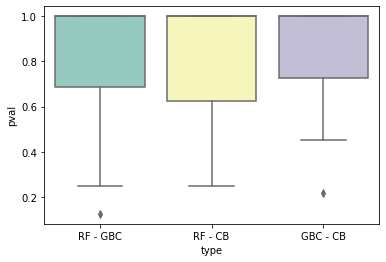

In [11]:
ax = sns.boxplot(x="type", y="pval", data=df_test, palette="Set3")
plt.savefig(os.path.join(path_extracted_data_cleaning,'ModelSelection_mcnemarTest.png'), bbox_inches='tight')
#we used exact=True, as some cells was<25 obs: https://machinelearningmastery.com/mcnemars-test-for-machine-learning/
#--> the binomial distribution was used
#p > alpha: fail to reject H0, no difference in the disagreement 
#p <= alpha: reject H0, significant difference in the disagreemen

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,algo,accuracy,value
523,CatBoost,accuracy_testing,0.989
223,CatBoost,accuracy_training,0.993
226,CatBoost,accuracy_training,0.996


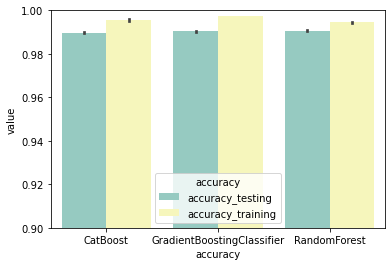

In [12]:
df_plt = pd.melt(df_results, id_vars=['algo'], value_vars=['accuracy_training', 'accuracy_testing'])
df_plt.sort_values(['algo'], inplace=True)
df_plt.rename(columns={'variable':'accuracy'}, inplace=True)
display(df_plt.head(3))
ax = sns.barplot(x="algo", y="value", hue="accuracy", data=df_plt, palette="Set3", ci=95)
plt.xlabel('')
plt.xlabel('accuracy')
plt.ylim(0.9,1);
plt.savefig(os.path.join(path_extracted_data_cleaning,'ModelSelection_accuracy.png'), bbox_inches='tight')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,algo,accuracy,value
523,CatBoost,accuracy_testing,0.989
223,CatBoost,accuracy_training,0.993
226,CatBoost,accuracy_training,0.996


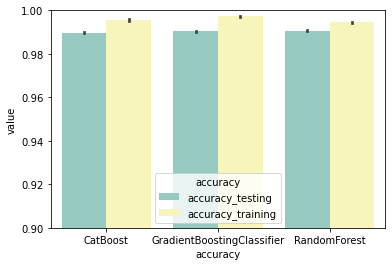

In [15]:
df_plt = pd.melt(df_results, id_vars=['algo'], value_vars=['accuracy_training', 'accuracy_testing'])
df_plt.sort_values(['algo'], inplace=True)
df_plt.rename(columns={'variable':'accuracy'}, inplace=True)
display(df_plt.head(3))
ax = sns.barplot(x="algo", y="value", hue="accuracy", data=df_plt, palette="Set3", ci=95)
plt.xlabel('')
plt.xlabel('accuracy')
plt.ylim(0.9,1);
plt.savefig(os.path.join(path_extracted_data_cleaning,'ModelSelection_accuracy.png'), bbox_inches='tight')

In [22]:
df_plt[df_plt['accuracy']=='accuracy_testing']['value'].min()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.987

In [23]:
df_plt[df_plt['accuracy']=='accuracy_testing']['value'].max()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.994

# Save best Classifier with fixed random seed

In [13]:
li_dico = []
model_final = CatBoostClassifier(min_data_in_leaf= 1,
                             cat_features= np.array(np.array(li_cat_select)),
                             n_estimators= 500,
                             max_depth= 8,
                             task_type= 'CPU',
                             class_weights= {0: 1, 1: 1},
                             use_best_model= True,
                             od_wait= 10,
                             od_pval= 1e-06,
                             loss_function= 'Logloss',
                             l2_leaf_reg= 2,  random_state=0)
model_final.fit(df_X_train_cb, df_y_train_cb, eval_set=(df_X_val_cb,df_y_val_cb) , verbose=False)
name_ = 'FINAL_Catboost'
li_dico.append({'algo':name_, 'model_param_used':model_final.get_all_params(), 
                'accuracy_training':round(model_final.score(df_X_train_cb, df_y_train_cb),3),
                'accuracy_validation':round(model_final.score(df_X_val_cb, df_y_val_cb),3),
                'accuracy_testing':round(model_final.score(df_X_test_cb, df_y_test_cb),3)})
#save
model_final.save_model(os.path.join(path_extracted_data_cleaning_model,name_),format="cbm")
pd.DataFrame(li_dico)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,algo,model_param_used,accuracy_training,accuracy_validation,accuracy_testing
0,FINAL_Catboost,"{'nan_mode': 'Min', 'eval_metric': 'Logloss', ...",0.999,0.993,0.989


# Most influential training observation

dataset = Pool(data=df_X_test_cb,
               cat_features=np.array(np.array(li_cat_select)),
               label=df_y_test_cb)

train_dataset = Pool(data=df_X_train_cb,
                     label=df_y_train_cb,
                     cat_features=np.array(np.array(li_cat_select)))
#top_size=Defines the number of most important objects from the training dataset. The number of returned objects is limited to this number.
indices, scores = model.get_object_importance(pool=dataset, train_pool=train_dataset, update_method='AllPoints',
                                             top_size=10) #, type='PerObject': better not to use, simpler without
#pd.DataFrame([indices,scores]).transpose()
df_X_train_cb.iloc[indices]